In [99]:
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.dates as mdates
from IPython.display import HTML

from load import Trailer

%matplotlib notebook

In [34]:
def get_ts(ms):
    return datetime.datetime.fromtimestamp(ms / 1000)

SENSORS = ["ACCELEROMETER", "GYROSCOPE", "TEMPERATURE", "MAGNETOMETER", "LIGHT"] # ["BAROMETER"]
MEANCENTER = set(["MAGNETOMETER"])
NORM = set(["MAGNETOMETER"])
LOGSENS = set(["LIGHT"])

(105, 3) (105, 3)


<IPython.core.display.Javascript object>


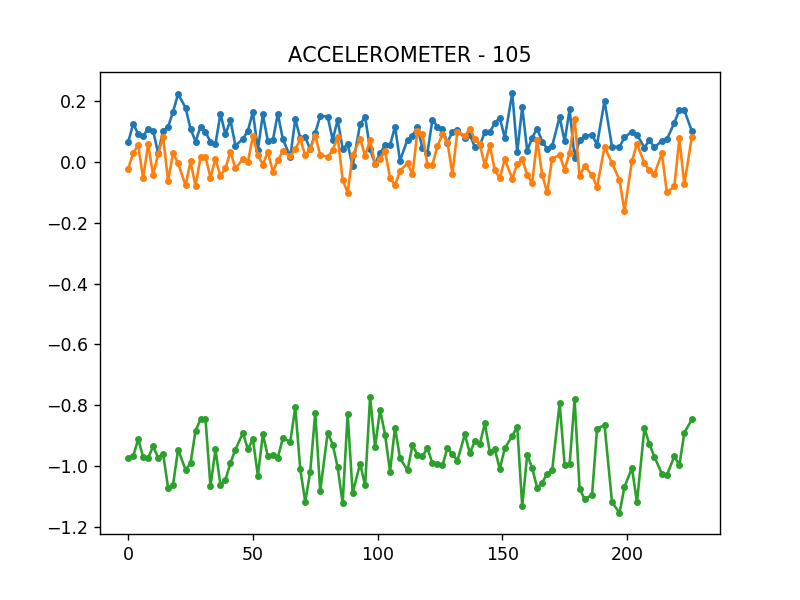

(105, 3) (105, 3)


<IPython.core.display.Javascript object>


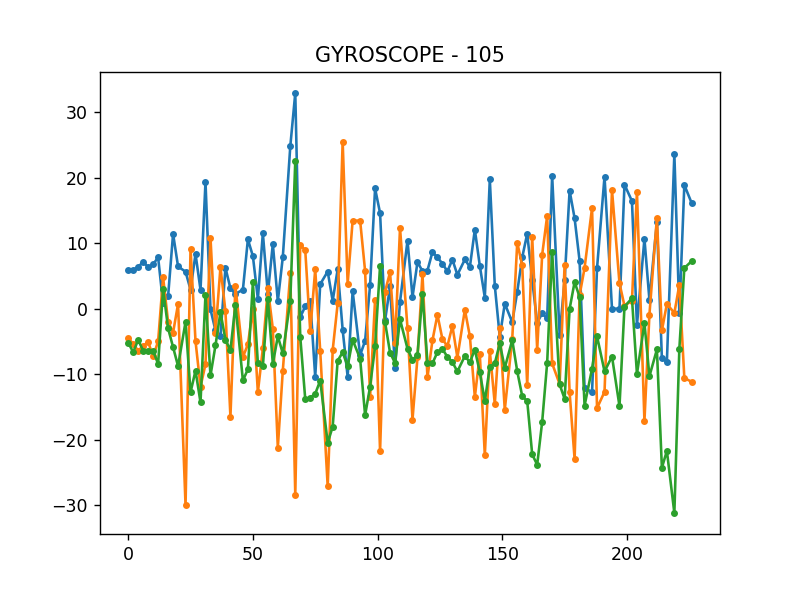

(105, 2) (105, 2)


<IPython.core.display.Javascript object>


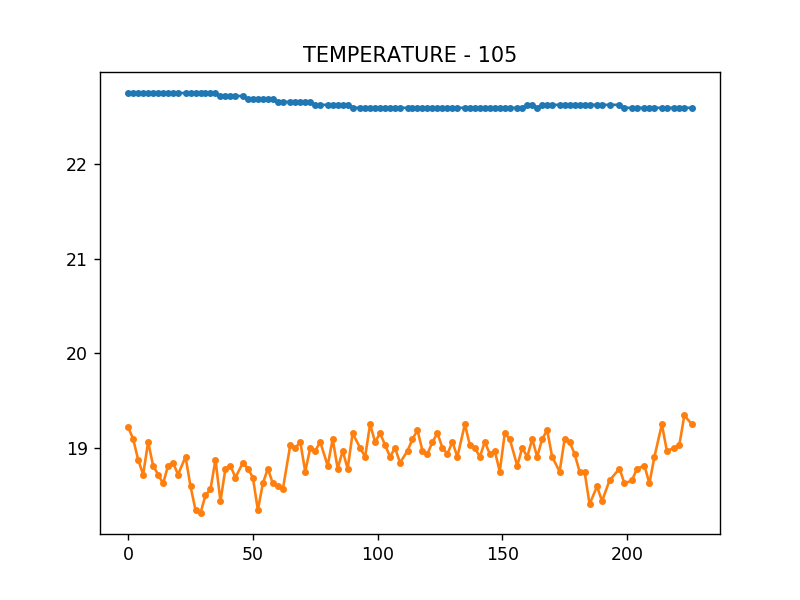

(105, 3) (105, 3)


<IPython.core.display.Javascript object>


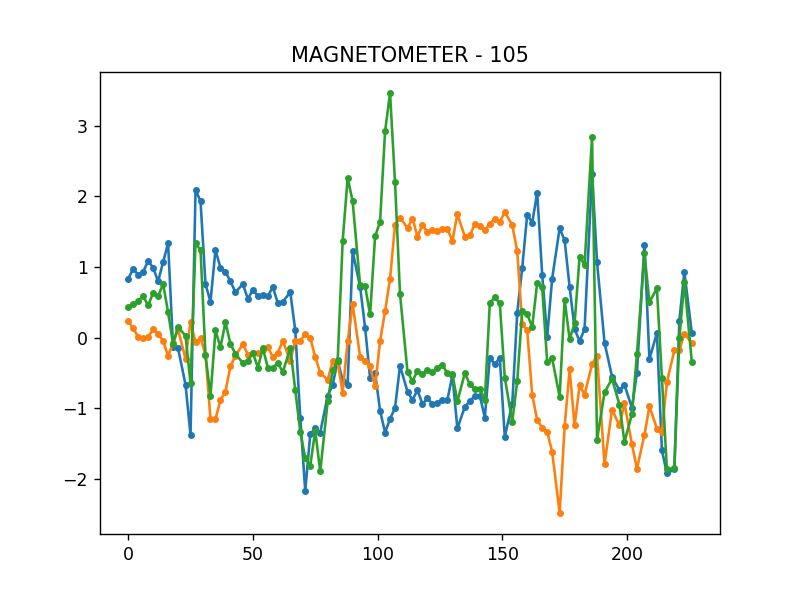

(105,) (105,)


<IPython.core.display.Javascript object>


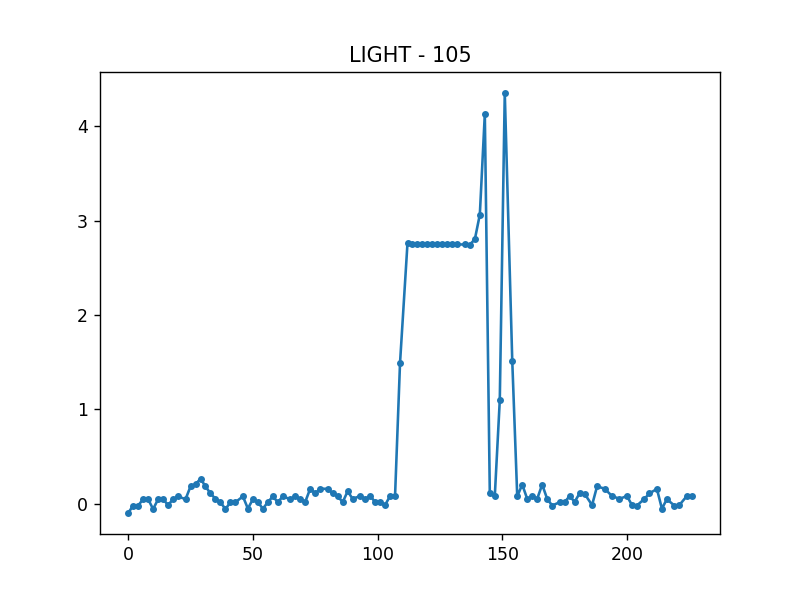

In [58]:
jsonfiles = ["../data/trailer-A.json", "../data/trailer-D.json"]
splits = [[(0.00, 228.00), (228.00, 432.00)], [(0.00, 212.00), (212.00, 418.00)]]
trailers = Trailer(jsonfiles)
data = trailers.load_and_split(splits)
data = data[0]
start_time = min(data.keys())
start_time = 0
for sensor in SENSORS:
    timeseries = [(get_ts((k - start_time)),v[sensor]["values"]) for k, v in data.items() if sensor in v]
    X, Y = zip(*timeseries)
    X, Y = np.array([(x - X[0]).seconds for x in X]), np.array(Y)
    if len(Y.shape) == 2:
        Y_len = Y.shape[1]
        X = np.tile(X, Y_len).reshape(Y_len, -1).T
    if sensor in MEANCENTER:
        Y -= Y.mean(axis=0)
        #Y += np.abs(Y.min(axis=0))
        #Y += 1e-8
    if sensor in NORM:
        Y /= Y.std(axis=0)
    if sensor in LOGSENS:
        Y = np.log10(Y)
    print(X.shape, Y.shape)
    plt.figure()
    plt.title("{} - {}".format(sensor, len(Y)))
    #plt.plot(X, Y, linestyle='None', marker=".")
    plt.plot(X, Y, marker=".")
    plt.show()

In [37]:


    
#gyroA = [(get_ts((k - start_time)),v["GYROSCOPE"]["values"]) for k, v in trailerA.data.items() if "GYROSCOPE" in v]
#gyroX, gyroY = zip(*gyroA)
#plt.plot(gyroX, gyroY)

KeyError: 0

<IPython.core.display.Javascript object>


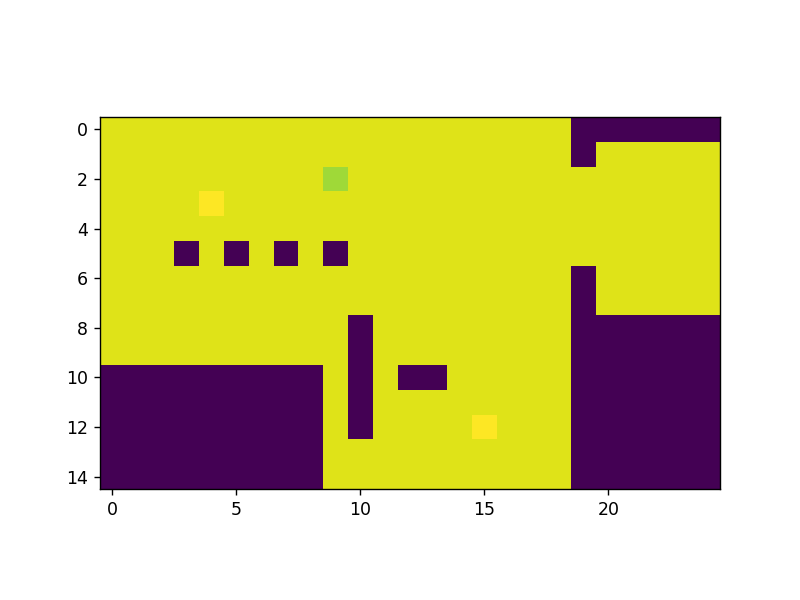

In [77]:
MIN_PLANT_VALUE = -1
MAX_PLANT_VALUE = 0.5
GOAL_VALUE = 10
EDGE_VALUE = -10
VISIBLE_RADIUS = 1

world = np.zeros((30, 50))
small_wall = 41
small_top = 2
small_bot = -13
small_dtop = 5
small_dbot = -18
left_bot = -10
left_wall = 18
ob1 = ((-10, 24), (-7, 27))
ob2 = ((-13, 19), (-4, 22))
ob3 = ((9, 6), (12, 9))
loading = ((-7, 30), (-6, 31))
warehouse = ((5, 8), (6, 9))
trap = ((3, 17), (4, 18))
world[:small_top, small_wall:] = EDGE_VALUE
world[small_bot:, small_wall:] = EDGE_VALUE
world[:small_dtop, small_wall - 1] = EDGE_VALUE
world[small_dbot:, small_wall - 1] = EDGE_VALUE
world[left_bot:, :left_wall] = EDGE_VALUE
world[ob1[0][0]:ob1[1][0], ob1[0][1]:ob1[1][1]] = EDGE_VALUE
world[ob2[0][0]:ob2[1][0], ob2[0][1]:ob2[1][1]] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], ob3[0][1]:ob3[1][1]] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], (ob3[0][1]+4):(ob3[1][1]+4)] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], (ob3[0][1]+8):(ob3[1][1]+8)] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], (ob3[0][1]+12):(ob3[1][1]+12)] = EDGE_VALUE
world[loading[0][0]:loading[1][0], loading[0][1]:loading[1][1]] = MAX_PLANT_VALUE
world[warehouse[0][0]:warehouse[1][0], warehouse[0][1]:warehouse[1][1]] = MAX_PLANT_VALUE
world[trap[0][0]:trap[1][0], trap[0][1]:trap[1][1]] = MIN_PLANT_VALUE

world = np.zeros((15, 25))
small_wall = 20
small_top = 1
small_bot = -7
small_dtop = 2
small_dbot = -9
left_bot = -5
left_wall = 9
ob1 = ((-5, 12), (-4, 14))
ob2 = ((-7, 10), (-2, 11))
ob3 = ((5, 3), (6, 4))
loading = (-3, 15)
warehouse = (3, 4)
trap = (2, 9)
world[:small_top, small_wall:] = EDGE_VALUE
world[small_bot:, small_wall:] = EDGE_VALUE
world[:small_dtop, small_wall - 1] = EDGE_VALUE
world[small_dbot:, small_wall - 1] = EDGE_VALUE
world[left_bot:, :left_wall] = EDGE_VALUE
world[ob1[0][0]:ob1[1][0], ob1[0][1]:ob1[1][1]] = EDGE_VALUE
world[ob2[0][0]:ob2[1][0], ob2[0][1]:ob2[1][1]] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], ob3[0][1]:ob3[1][1]] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], (ob3[0][1]+2):(ob3[1][1]+2)] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], (ob3[0][1]+4):(ob3[1][1]+4)] = EDGE_VALUE
world[ob3[0][0]:ob3[1][0], (ob3[0][1]+6):(ob3[1][1]+6)] = EDGE_VALUE
world[loading[0], loading[1]] = MAX_PLANT_VALUE
world[warehouse[0], warehouse[1]] = MAX_PLANT_VALUE
world[trap[0], trap[1]] = MIN_PLANT_VALUE



plt.figure()
plt.imshow(world)
plt.show()    


In [78]:
START_HEALTH = 1
STEP_VALUE = -0.002

class Grid():
    def __init__(self, grid=None):
        self.grid_empty = grid
        self.grid_size = {"x": 25, "y": 15}
        
    def reset(self):
        self.grid = self.grid_empty.copy() # Padding for edges
        
        # Edges
        self.grid[0:VISIBLE_RADIUS, :] = EDGE_VALUE
        self.grid[-1*VISIBLE_RADIUS:, :] = EDGE_VALUE
        self.grid[:, 0:VISIBLE_RADIUS] = EDGE_VALUE
        self.grid[:, -1*VISIBLE_RADIUS:] = EDGE_VALUE
        
        # Randomly placed plants
        #for i in range(self.n_plants):
        #    plant_value = random.random() * (MAX_PLANT_VALUE - MIN_PLANT_VALUE) + MIN_PLANT_VALUE
        #    ry = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
        #    rx = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
        #    self.grid[ry, rx] = plant_value
 
        # Goal in one of the corners
        #S = VISIBLE_RADIUS
        #E = self.grid_size + VISIBLE_RADIUS - 1
        #gps = [(E, E), (S, E), (E, S), (S, S)]
        #gp = gps[random.randint(0, len(gps)-1)]
        #self.grid[gp] = GOAL_VALUE
    
    def visible(self, pos):
        y, x = pos
        return self.grid[y-VISIBLE_RADIUS:y+VISIBLE_RADIUS+1, x-VISIBLE_RADIUS:x+VISIBLE_RADIUS+1]


class Agent:
    def reset(self):
        self.health = START_HEALTH

    def act(self, action):
        # Move according to action: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        y, x = self.pos
        if action == 1: 
            x -= 1
            y += 1
        elif action == 2: 
            y += 1
        elif action == 3: 
            x += 1
            y += 1
        elif action == 4: 
            x -= 1
        elif action == 5:
            pass
        elif action == 6: 
            x += 1
        elif action == 7: 
            x -= 1
            y -= 1
        elif action == 8: 
            y -= 1
        elif action == 9: 
            x += 1
            y -= 1
        self.pos = (y, x)
        self.health += STEP_VALUE # Gradually getting hungrier
        
class Environment:
    def __init__(self):
        self.grid = Grid(world)
        self.agent = Agent()

    def reset(self):
        """Start a new episode by resetting grid and agent"""
        self.grid.reset()
        self.agent.reset()
        #c = math.floor(self.grid.grid_size / 2)
        self.agent.pos = (3, 22)
        
        self.t = 0
        self.history = []
        self.record_step()
        
        return self.visible_state
    
    def record_step(self):
        """Add the current state to history for display later"""
        grid = np.array(self.grid.grid)
        grid[self.agent.pos] = self.agent.health * 0.5 # Agent marker faded by health
        visible = np.array(self.grid.visible(self.agent.pos))
        self.history.append((grid, visible, self.agent.health))
    
    @property
    def visible_state(self):
        """Return the visible area surrounding the agent, and current agent health"""
        visible = self.grid.visible(self.agent.pos)
        y, x = self.agent.pos
        yp = (y - VISIBLE_RADIUS) / self.grid.grid_size["y"]
        xp = (x - VISIBLE_RADIUS) / self.grid.grid_size["x"]
        extras = [self.agent.health, yp, xp]
        return np.concatenate((visible.flatten(), extras), 0)
    
    def step(self, action):
        """Update state (grid and agent) based on an action"""
        self.agent.act(action)
        
        # Get reward from where agent landed, add to agent health
        value = self.grid.grid[self.agent.pos]
        self.grid.grid[self.agent.pos] = 0
        self.agent.health += value
        
        # Check if agent won (reached the goal) or lost (health reached 0)
        won = value == GOAL_VALUE
        lost = self.agent.health <= 0
        done = won or lost
        
        # Rewards at end of episode
        if won:
            reward = 1
        elif lost:
            reward = -1
        else:
            reward = 0 # Reward will only come at the end

        # Save in history
        self.record_step()
        
        return self.visible_state, reward, done

In [79]:
def animate(history):
    frames = len(history)
    print("Rendering %d frames..." % frames)
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)
    fig_health = fig.add_subplot(243)
    fig_visible = fig.add_subplot(244)
    fig_health.set_autoscale_on(False)
    health_plot = np.zeros((frames, 1))

    def render_frame(i):
        grid, visible, health = history[i]
        # Render grid
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
        fig_visible.matshow(visible, vmin=-1, vmax=1, cmap='jet')
        # Render health chart
        health_plot[i] = health
        fig_health.clear()
        fig_health.axis([0, frames, 0, 2])
        fig_health.plot(health_plot[:i + 1])

    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=100
    )

    plt.close()
    display(HTML(anim.to_html5_video()))

In [97]:
env = Environment()
env.reset()
print(env.visible_state)

done = False
while not done:
    _, _, done = env.step(np.random.choice([1, 2, 3, 4, 6, 7, 8, 9])) # random

print(len(env.history), type(env.history))
animate_hist = env.history if len(env.history) < 50 else env.history[:50]
#animate(animate_hist)

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.13333333  0.84      ]
4 <class 'list'>


In [131]:
class Simple(nn.Module):
    def __init__(self):
        super(Simple, self).__init__()
        self.l1 = nn.Linear(10, 100)
        self.fc = nn.Linear(100, 9)
    def forward(self, input):
        x = F.relu(self.l1(input))
        x = F.softmax(self.fc(x), dim=-1)
        return x

model = Simple()
#dummy = torch.zeros(10)
#dummy.unsqueeze_(0)
#dummy.unsqueeze_(0)
#dummy = Variable(dummy)
#out = model(dummy)


KEEPFEATURES = ["ACCELEROMETER", "GYROSCOPE", "MAGNETOMETER", "LIGHT"]

jsonfiles = ["../data/trailer-A.json", "../data/trailer-D.json"]
splits = [[(0.00, 228.00), (228.00, 432.00)], [(0.00, 212.00), (212.00, 418.00)]]
trailers = Trailer(jsonfiles)
data = trailers.load_and_split(splits)
finalY = None
for sensor in KEEPFEATURES:
    timeseries = [(get_ts((k - start_time)),v[sensor]["values"]) for k, v in data[0].items() if sensor in v]
    X, Y = zip(*timeseries)
    X, Y = np.array([(x - X[0]).seconds for x in X]), np.array(Y)
    if len(Y.shape) == 2:
        Y_len = Y.shape[1]
        X = np.tile(X, Y_len).reshape(Y_len, -1).T
    if sensor in MEANCENTER:
        Y -= Y.mean(axis=0)
        #Y += np.abs(Y.min(axis=0))
        #Y += 1e-8
    if sensor in NORM:
        Y /= Y.std(axis=0)
    if sensor in LOGSENS:
        Y = np.log10(Y)
    if len(Y.shape) == 1: Y = Y[:, None]
    finalY = Y if finalY is None else np.concatenate((finalY, Y), axis=1)

input = torch.from_numpy(finalY).float()
input.unsqueeze_(0)
input = Variable(input)
out = model(input)
actions = out.data.max(-1)[1]

(
 
 Columns 0 to 9 
  0.2299  0.2544  0.2697  0.2692  0.2486  0.2952  0.2704  0.1864  0.1559  0.2742
 
 Columns 10 to 19 
  0.2223  0.4444  0.3727  0.2690  0.4377  0.8324  0.2878  0.1936  0.1737  0.1766
 
 Columns 20 to 29 
  0.3849  0.1896  0.3309  0.3007  0.4982  0.3394  0.3057  0.2109  0.2415  0.4034
 
 Columns 30 to 39 
  0.3585  0.5934  0.9998  0.2138  0.4801  0.3855  0.5063  0.3580  0.7270  0.4837
 
 Columns 40 to 49 
  0.2037  0.5203  0.3589  0.3415  0.3301  0.5847  0.4425  0.3327  0.8921  0.1678
 
 Columns 50 to 59 
  0.2085  0.3193  0.3432  0.2585  0.3790  0.3551  0.2854  0.4033  0.3457  0.2432
 
 Columns 60 to 69 
  0.2978  0.3292  0.2956  0.3784  0.2396  0.3264  0.3960  0.3960  0.5603  0.4658
 
 Columns 70 to 79 
  0.3629  0.2258  0.3738  0.2062  0.2426  0.2398  0.4534  0.6059  0.6560  0.5630
 
 Columns 80 to 89 
  0.2711  0.9461  0.3304  0.3290  0.7979  0.8133  0.2680  0.5720  0.4121  0.3663
 
 Columns 90 to 99 
  0.4223  0.3626  0.4687  0.6060  0.5714  0.3227  0.4757  0.2